## 1. imports necesarios

In [24]:
import pandas as pd


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

import warnings

import matplotlib.pyplot as plt



warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## 2. cargar datos

In [25]:
iris_dataset = load_iris(as_frame=True)

X: pd.DataFrame = iris_dataset.data
y: pd.Series = iris_dataset.target

## 3. validacion de datos

#### validacion de las caracteristicas

In [3]:
# revisar la informacion del dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


- no se encuentran valores nulos en ninguna de las caracteristicas
- las caracteristicas tienen el tipo de datos correcto

In [4]:
# revisar duplicados
duplicados = X.duplicated(keep=False)

display(
    X[duplicados], 
    y[duplicados]
)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
101,5.8,2.7,5.1,1.9
142,5.8,2.7,5.1,1.9


101    2
142    2
Name: target, dtype: int64

- existe un registro duplicado (se eliminara en un paso posterior)

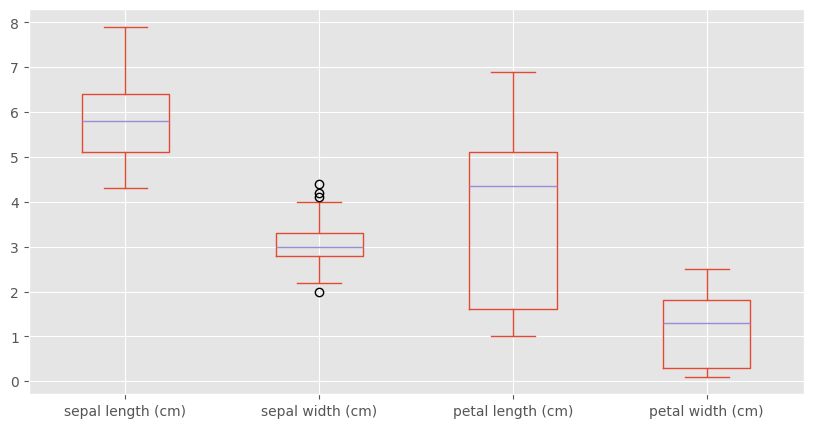

In [5]:
# revisar outliers
X.plot.box(figsize=(10, 5))

plt.show()

- no se detectan outliers en las caracteristicas, excepto en `sepal width`, sin embargo no es demasiado grave, y como se tienen pocos datos, se mantendran

#### validacion de la variable objetivo

In [6]:
# revisar valores nulos
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 150 entries, 0 to 149
Series name: target
Non-Null Count  Dtype
--------------  -----
150 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB


- no se encuentran valores nulos
- tiene el tipo de datos correcto

target
0    50
1    50
2    50
Name: count, dtype: int64

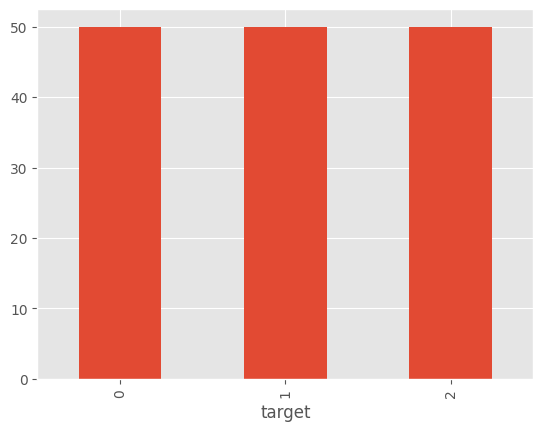

In [7]:
# revisar las clases
display(y.value_counts())

y.value_counts().plot.bar()

plt.show()

- estan balanceadas
- no hay valores de clase por fuera de las clases esperadas

## 4. preparacion de los datos

en la validacion de los datos, solo se encontro un registro duplicado, el cual se eliminara

In [8]:
X = X[~duplicados]
y = y[~duplicados]

In [9]:
# separar datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. entrenamiento del modelo

In [16]:
# buscar los mejores hiperparametros

param_grid = {
    'n_estimators': [20, 30 , 50],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(objective='multi:softmax')


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)


print("mejores hiperparametros: ", grid_search.best_params_)
print("mejor exactitud: ", grid_search.best_score_)

mejores hiperparametros:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20, 'subsample': 0.8}
mejor exactitud:  0.9583333333333334


## 6. evaluacion del modelo

In [19]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.83      1.00      0.91        10
           2       1.00      0.78      0.88         9

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



se obtiene una exactitud con datos de entrenamiento de 0.97 y con datos de prueba de 0.93, por lo que se puede decir que el modelo es bueno y no sufre de overfitting.

## 7. guardado del modelo

In [23]:
grid_search.best_estimator_.save_model("./../models/xgboost_model.json")